# Model Loading and Predicting
by Prince Joseph Erneszer Javier

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

from scipy.stats import kurtosis, skew
from scipy.signal import periodogram
from collections import Counter

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout

seed = 42
np.random.seed(seed)

import ast


## Loading Data

In [3]:
# paths of features and labels
path_feats ="data/processed/df_test.csv"
path_labels = "data/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv"

df_feats = pd.read_csv(path_feats).drop_duplicates()
df_labels = pd.read_csv(path_labels).drop_duplicates()

## Data Preprocessing

### Feature Engineering

In [4]:
def dominant_f(y):
    """Given time series y, get frequency of maximum power
    from periodogram"""
    f, p = periodogram(y, scaling='spectrum')
    ind = np.argsort(p)
    f_max = f[ind[-1]]
    return f_max

def max_power(y):
    """Given time series y, get maximum power"""
    f, p = periodogram(y, scaling='spectrum')
    return p.max()

In [5]:
# we engineer feature, aggregating feature values per bookingID
# getting min, max, range, mean, std, skewness, and kurtosis

df_engg_feats = df_feats.drop("second", axis=1)
df_engg_feats = df_engg_feats.groupby(by="bookingID", as_index=True).agg([np.min, np.max, np.ptp, np.mean, np.std, skew, kurtosis, dominant_f, max_power])
df_engg_feats.head()


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Accuracy                                                  \
               amin    amax     ptp       mean       std       skew   
bookingID                                                             
124             3.0  15.008  12.008   7.147938  2.486692   0.139104   
162             3.0  10.937   7.937   3.785293  0.476145   5.624208   
8589934624     10.0  32.000  22.000  10.433486  2.711012   6.648893   
8589934648      3.0  14.783  11.783   3.708070  0.524037   7.543774   
8589934652      3.0  32.000  29.000   3.958367  1.511782  12.225604   

                                              Bearing  ...    gyro_z Speed  \
              kurtosis dominant_f max_power      amin  ... max_power  amin   
bookingID                                              ...                   
124          -0.818033   0.001515  2.301588  0.000000  ...  0.000068   0.0   
162          79.958988   0.001307  0.038898  0.000000  ...  0.000031  -1.0   
8589934624   43.923071   0.071101  0.253124  0.258441  ...  0.000043  -1.0   
8589934648  152.981841   0.001254  0.037887  0.000000  ...  0.000011   0.0   
8589934652  193.562775   0.000608  0.175594  0.000000  ...  0.000041  -1.0   

                                                                           \
                 amax        ptp       mean       std      skew  kurtosis   
bookingID                                                                   
124         13.920000  13.920000   4.553212  4.370550  0.438431 -1.173504   
162         27.980000  28.980000  14.892732  8.908004 -0.412321 -1.120888   
8589934624  21.049999  22.049999   4.872339  5.933472  1.396884  0.578838   
8589934648  24.020000  24.020000  10.398451  7.463056 -0.108021 -1.333071   
8589934652  27.426030  28.426030  14.777113  9.330526 -0.507820 -1.344912   

                                  
           dominant_f  max_power  
bookingID                         
124          0.004545   2.685770  
162          0.001307  44.453907  
8589934624   0.006881  10.271049  
8589934648   0.001254  13.539801  
8589934652   0.000608  57.086808  

[5 rows x 81 columns]

In [6]:
# flatten column names
cols = [df_engg_feats.columns[i][0]+"_"+df_engg_feats.columns[i][1] for i in range(len(df_engg_feats.columns))]

In [7]:
df_engg_feats.columns = cols
df_engg_feats.reset_index(inplace=True)
df_engg_feats.head()

,bookingID,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,...,gyro_z_max_power,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power
0,124,3.0,15.008,12.008,7.147938,2.486692,0.139104,-0.818033,0.001515,2.301588,...,0.000068,0.0,13.920000,13.920000,4.553212,4.370550,0.438431,-1.173504,0.004545,2.685770
1,162,3.0,10.937,7.937,3.785293,0.476145,5.624208,79.958988,0.001307,0.038898,...,0.000031,-1.0,27.980000,28.980000,14.892732,8.908004,-0.412321,-1.120888,0.001307,44.453907
2,8589934624,10.0,32.000,22.000,10.433486,2.711012,6.648893,43.923071,0.071101,0.253124,...,0.000043,-1.0,21.049999,22.049999,4.872339,5.933472,1.396884,0.578838,0.006881,10.271049
3,8589934648,3.0,14.783,11.783,3.708070,0.524037,7.543774,152.981841,0.001254,0.037887,...,0.000011,0.0,24.020000,24.020000,10.398451,7.463056,-0.108021,-1.333071,0.001254,13.539801
4,8589934652,3.0,32.000,29.000,3.958367,1.511782,12.225604,193.562775,0.000608,0.175594,...,0.000041,-1.0,27.426030,28.426030,14.777113,9.330526,-0.507820,-1.344912,0.000608,57.086808


In [8]:
# add length of each trip
df_len = df_feats.groupby(by="bookingID", as_index=True).agg(len).iloc[:, 0:1]
df_len.columns = ['trip_len']
df_len.reset_index(inplace=True)
df_len.head()

,bookingID,trip_len
0,124,660.0
1,162,765.0
2,8589934624,436.0
3,8589934648,1595.0
4,8589934652,1645.0


In [9]:
# merge along bookingID
df_engg_feats_2 = pd.merge(df_engg_feats, df_len, how="inner", on="bookingID")
df_engg_feats_2.head()

,bookingID,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,...,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power,trip_len
0,124,3.0,15.008,12.008,7.147938,2.486692,0.139104,-0.818033,0.001515,2.301588,...,0.0,13.920000,13.920000,4.553212,4.370550,0.438431,-1.173504,0.004545,2.685770,660.0
1,162,3.0,10.937,7.937,3.785293,0.476145,5.624208,79.958988,0.001307,0.038898,...,-1.0,27.980000,28.980000,14.892732,8.908004,-0.412321,-1.120888,0.001307,44.453907,765.0
2,8589934624,10.0,32.000,22.000,10.433486,2.711012,6.648893,43.923071,0.071101,0.253124,...,-1.0,21.049999,22.049999,4.872339,5.933472,1.396884,0.578838,0.006881,10.271049,436.0
3,8589934648,3.0,14.783,11.783,3.708070,0.524037,7.543774,152.981841,0.001254,0.037887,...,0.0,24.020000,24.020000,10.398451,7.463056,-0.108021,-1.333071,0.001254,13.539801,1595.0
4,8589934652,3.0,32.000,29.000,3.958367,1.511782,12.225604,193.562775,0.000608,0.175594,...,-1.0,27.426030,28.426030,14.777113,9.330526,-0.507820,-1.344912,0.000608,57.086808,1645.0


In [10]:
# left join with labels (aggregating and feature engineering)
df_engg_feats_labels = pd.merge(df_engg_feats_2, df_labels, how="inner", on="bookingID")
df_engg_feats_labels.head()

,bookingID,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,...,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power,trip_len,label
0,124,3.0,15.008,12.008,7.147938,2.486692,0.139104,-0.818033,0.001515,2.301588,...,13.920000,13.920000,4.553212,4.370550,0.438431,-1.173504,0.004545,2.685770,660.0,0
1,162,3.0,10.937,7.937,3.785293,0.476145,5.624208,79.958988,0.001307,0.038898,...,27.980000,28.980000,14.892732,8.908004,-0.412321,-1.120888,0.001307,44.453907,765.0,0
2,8589934624,10.0,32.000,22.000,10.433486,2.711012,6.648893,43.923071,0.071101,0.253124,...,21.049999,22.049999,4.872339,5.933472,1.396884,0.578838,0.006881,10.271049,436.0,0
3,8589934648,3.0,14.783,11.783,3.708070,0.524037,7.543774,152.981841,0.001254,0.037887,...,24.020000,24.020000,10.398451,7.463056,-0.108021,-1.333071,0.001254,13.539801,1595.0,0
4,8589934652,3.0,32.000,29.000,3.958367,1.511782,12.225604,193.562775,0.000608,0.175594,...,27.426030,28.426030,14.777113,9.330526,-0.507820,-1.344912,0.000608,57.086808,1645.0,0


In [11]:
df_engg_feats_labels.drop_duplicates(subset="bookingID", inplace=True)
df_engg_feats_labels.shape

(1000, 84)

In [111]:
# get feature set
X0 = df_engg_feats_2.drop(["bookingID"], axis=1)
cols = X0.columns

In [112]:
y = df_engg_feats_labels.label
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [113]:
# 0s and 1s
Counter(y)

Counter({0: 736, 1: 264})

In [114]:
# proportional chance criterion
state_counts = Counter(y)
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
num = (df_state[0] / df_state[0].sum())**2
pcc = num.sum()
pcc

0.6113919999999999

## Model Predicting

In [177]:
# ensemble of top models

def predict_all(scaler="minmax"):
    
    """
    Given scaler name, scale dataset and predict using pretrained models
    Uses all features
    Return prediction as array of 0s and 1s from all models
    """

    # scaling
    path = f"scalers/{scaler}.sav"
    sc = pickle.load(open(path, 'rb'))
    
    y_preds = []

    # scale X
    X = pd.DataFrame(sc.transform(X0))
    X.columns = cols

    model_names = [f"models/{model}_{scaler}.sav" for model in ['gbm', 'svc', 'linear_svc_l1', 'linear_svc_l2', 'log_reg', 'rf']]

    for model_name in model_names:
        # load the model from disk (machine learning)
        filename = model_name
        model = pickle.load(open(filename, 'rb'))
        y_pred = model.predict(X)
        print(accuracy_score(y, y_pred), model_name)

        y_preds.append(y_pred)

    # Deep learning
    filename = f"models/mlp_{scaler}_relu_adam_dropout-0.5_cols-82.hdf5"
    model = load_model(filename)
    y_pred_2 = np.round(model.predict(X))
    print(accuracy_score(y, y_pred_2), f"nn_{scaler}")
    
    y_preds.append(y_pred_2)
    accuracies.append(accuracy_score(y, y_pred_2))
    
    return y_preds


In [ ]:
def predict_select_features()

In [174]:
y_pred_minmax = predict("minmax")
y_pred_std = predict("std")

# concatenate results from std and minmax models
y_pred_all = y_pred_std + y_pred_minmax

# get average of all values
y_pred = np.round(np.array([np.array(i).flatten() for i in y_pred_all]).mean(axis=0), 0)

0.681 models/gbm_minmax.sav
0.681 models/svc_minmax.sav
0.662 models/linear_svc_l1_minmax.sav
0.697 models/linear_svc_l2_minmax.sav
0.663 models/log_reg_minmax.sav
0.688 models/rf_minmax.sav
0.676 nn_minmax
0.671 models/gbm_std.sav
0.693 models/svc_std.sav
0.664 models/linear_svc_l1_std.sav
0.683 models/linear_svc_l2_std.sav
0.663 models/log_reg_std.sav
0.696 models/rf_std.sav
0.698 nn_std


In [175]:
# Evaluation
accuracy_score(y, y_pred)

0.696

Confusion matrix, without normalization
[[551 185]
 [119 145]]
Normalized confusion matrix
[[0.75 0.25]
 [0.45 0.55]]


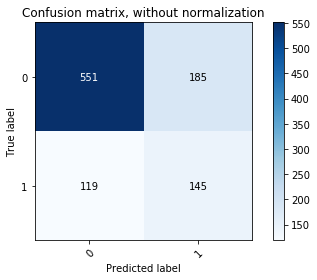

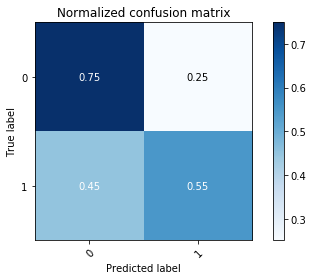

In [176]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0, 1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names = [0, 1]

# Plot non-normalized confusion matrix
plot_confusion_matrix(y, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()